In [1]:
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import seaborn as sns
import rasterio
import laspy
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree

In [237]:
plot1 = laspy.read("/home/rafael/Projetos/tree_detection/data/als/plot_03.las")

In [238]:
points = np.vstack((plot1.x, plot1.y, plot1.z)).T
points

array([[5.46579922e+05, 6.45016205e+06, 1.79061000e+02],
       [5.46580254e+05, 6.45016224e+06, 1.79081000e+02],
       [5.46580290e+05, 6.45016137e+06, 1.80153000e+02],
       ...,
       [5.46603763e+05, 6.45020879e+06, 1.94885000e+02],
       [5.46603412e+05, 6.45020815e+06, 1.94176000e+02],
       [5.46607057e+05, 6.45020432e+06, 1.74891000e+02]],
      shape=(301556, 3))

In [239]:
heights = points[:, 2]
heights

array([179.061, 179.081, 180.153, ..., 194.885, 194.176, 174.891],
      shape=(301556,))

In [240]:
min_z = np.percentile(heights, 5) #filter ground points - test different percentiles
mask = heights > min_z
points = points[mask]
heights = heights[mask]

In [241]:
tree = cKDTree(points[:, :2])
radius = 1.3 # test out different radius

is_local_max = np.zeros(len(points), dtype=bool) # we declare a is_local_max with same length as the points
for i, (x, y, z) in enumerate(points): #iterate over all points
    idx = tree.query_ball_point([x, y], radius) # we query to get idx
    if z >= np.max(heights[idx]): # if z is higher than the max height at that idx 
        is_local_max[i] = True # we set a local_max


treetops = points[is_local_max] # filter out points that are local maxes - possible treetops
print(f"Detected {len(treetops)} local maxima (candidate treetops)")

Detected 417 local maxima (candidate treetops)


In [242]:
tree_tops = cKDTree(treetops[:, :2])
_, nearest_top_idx = tree_tops.query(points[:, :2], k=1)

cluster_labels = nearest_top_idx

In [243]:
df = pd.DataFrame({
    "x": points[:, 0],
    "y": points[:, 1],
    "z": points[:, 2],
    "cluster": cluster_labels
})


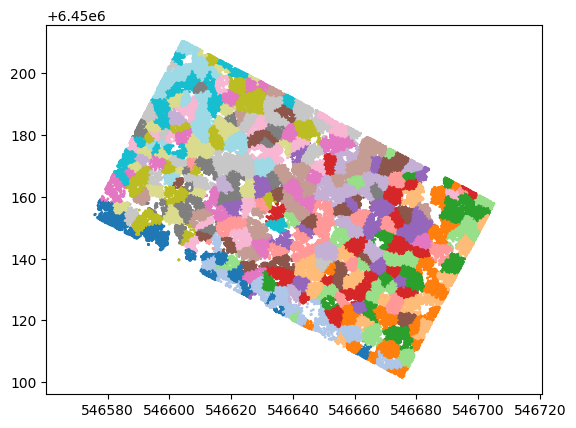

In [244]:
import matplotlib.pyplot as plt
plt.scatter(df.x, df.y, c=df.cluster, s=1, cmap='tab20')
plt.axis('equal')
plt.show()

In [246]:
detections = (
    df.groupby("cluster")[["x", "y", "z"]]
      .mean()
      .reset_index()
)

In [247]:
treetops = (
    df.loc[df.groupby("cluster")["z"].idxmax(), ["cluster", "x", "y", "z"]]
    .reset_index(drop=True)
)

In [248]:
len(treetops)

400

In [249]:
treetops

,cluster,x,y,z
0,0,546584.430,6.450152e+06,189.750
1,1,546594.130,6.450148e+06,188.806
2,2,546576.789,6.450153e+06,185.065
3,3,546580.650,6.450153e+06,189.750
4,4,546585.637,6.450148e+06,183.417
...,...,...,...,...
395,412,546597.653,6.450198e+06,189.955
396,413,546610.154,6.450188e+06,195.706
397,414,546604.542,6.450192e+06,196.852
398,415,546599.856,6.450201e+06,190.964


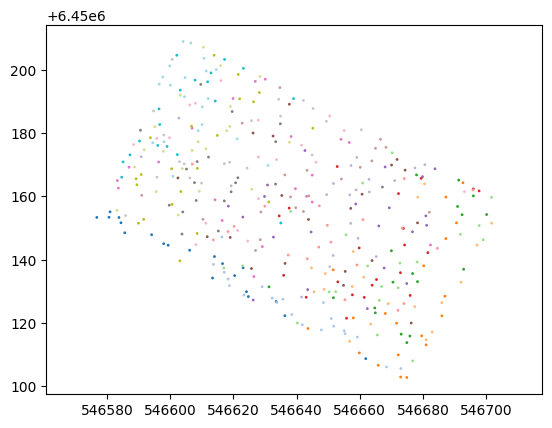

In [250]:
import matplotlib.pyplot as plt
plt.scatter(treetops.x, treetops.y, c=treetops.cluster, s=1, cmap='tab20')
plt.axis('equal')
plt.show()

In [251]:
geometry = gpd.points_from_xy(treetops['x'], treetops['y'])

tree_gdf = gpd.GeoDataFrame(treetops, geometry=geometry, crs="EPSG:32640")
tree_gdf

,cluster,x,y,z,geometry
0,0,546584.430,6.450152e+06,189.750,POINT (546584.43 6450151.652)
1,1,546594.130,6.450148e+06,188.806,POINT (546594.13 6450147.865)
2,2,546576.789,6.450153e+06,185.065,POINT (546576.789 6450153.335)
3,3,546580.650,6.450153e+06,189.750,POINT (546580.65 6450153.379)
4,4,546585.637,6.450148e+06,183.417,POINT (546585.637 6450148.471)
...,...,...,...,...,...
395,412,546597.653,6.450198e+06,189.955,POINT (546597.653 6450197.736)
396,413,546610.154,6.450188e+06,195.706,POINT (546610.154 6450188.345)
397,414,546604.542,6.450192e+06,196.852,POINT (546604.542 6450191.527)
398,415,546599.856,6.450201e+06,190.964,POINT (546599.856 6450201.273)


In [252]:
gt = gpd.read_file("/home/rafael/Projetos/tree_detection/data/field_survey.geojson")

In [253]:
ground_truth = gt.query("plot==3")

In [254]:
def evaluate(detected, ground_truth, max_dist=5.0):

    if len(detected) == 0 or len(ground_truth) == 0:
        return 0, 0, 0
        
    tree_gt = cKDTree(ground_truth[:, :2])
    matches = 0
        
    for det_tree in detected:
        dist, _ = tree_gt.query(det_tree[:2])
        if dist <= max_dist:
            matches += 1
        
    recall = matches / len(ground_truth)
    precision = matches / len(detected)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
    return recall, precision, f1

In [ ]:
gt_coords = [[geom.x, geom.y] for geom in ground_truth.geometry]
gt = np.array(gt_coords)


gt

In [256]:
detected_coords = [[geom.x, geom.y] for geom in tree_gdf.geometry]
detected = np.array(detected_coords)

In [257]:
r, p, f1 = evaluate(detected, gt, max_dist=5)

In [258]:
print(r, p, f1)

0.891566265060241 0.74 0.8087431693989071


<Axes: >

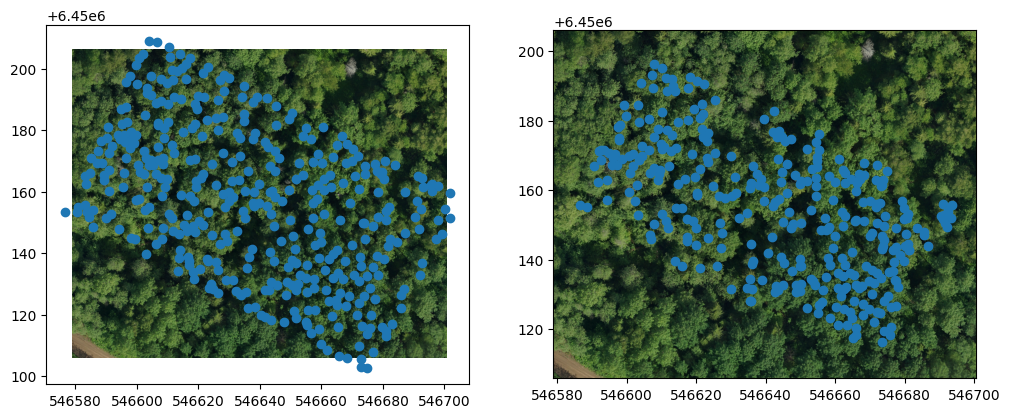

In [260]:
p1 = rasterio.open("/home/rafael/Projetos/tree_detection/data/ortho/plot_03.tif")

from rasterio.plot import show

fig, axes = plt.subplots(1, 2, figsize=(12,12))
extent = [p1.bounds[0], p1.bounds[2], p1.bounds[1], p1.bounds[3]]
ax = rasterio.plot.show(p1, extent=extent, ax=axes[0])
tree_gdf.plot(ax = axes[0])

ax = rasterio.plot.show(p1, extent=extent, ax=axes[1])
ground_truth.plot(ax = axes[1])

In [26]:
from shapely.geometry import Point

In [27]:
las = laspy.read("/home/rafael/Projetos/tree_detection/data/als/plot_01.las")

rgb = rasterio.open("/home/rafael/Projetos/tree_detection/data/ortho/plot_01.tif")


In [132]:
ground_level = np.percentile(las.xyz[:, 2], 3)

In [134]:
las.xyz[:,2] = las.xyz[:,2] - ground_level

In [135]:
las = las[las.xyz[:, 2] > 2.0]

In [138]:
points  = pd.DataFrame({
    "x": las.x.copy(),
    "y": las.y.copy(),
    "z": las.z.copy(),
    "intensity": las.intensity.copy()})
gdf_las = gpd.GeoDataFrame(points,geometry = gpd.points_from_xy(points.x, points.y), crs ="EPSG:32640" )

In [139]:
gdf_las.shape

(218873, 5)

In [141]:
from rasterio.sample import sample_gen 

coords = [(x,y) for x,y in zip(gdf_las.x,gdf_las.y)]

r, g, b = [], [], []

for val in rgb.sample(coords):
    r.append(val[0])
    g.append(val[1])
    b.append(val[2])

gdf_las["r"] = r
gdf_las["g"] = g
gdf_las["b"] = b

In [142]:
gdf_las.head(3)

,x,y,z,intensity,geometry,r,g,b
0,547126.022,6.450332e+06,192.615,39,POINT (547126.022 6450332.462),68,109,48
1,547124.386,6.450323e+06,210.831,39,POINT (547124.386 6450323.417),72,109,38
2,547123.899,6.450323e+06,210.599,39,POINT (547123.899 6450322.772),255,255,255


In [143]:
trees = ground_truth

In [144]:
trees["geometry"] = trees.geometry.buffer(0.5)

In [145]:
gdf_join = gpd.sjoin(gdf_las, trees, predicate = "within", how = "left")

In [146]:
gdf_join.head(3)

,x,y,z,intensity,geometry,r,g,b,index_right,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment
0,547126.022,6.450332e+06,192.615,39,POINT (547126.022 6450332.462),68,109,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,547124.386,6.450323e+06,210.831,39,POINT (547124.386 6450323.417),72,109,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,547123.899,6.450323e+06,210.599,39,POINT (547123.899 6450322.772),255,255,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
agg = (
    gdf_join[gdf_join["tree_no"].notna()].groupby("tree_no").agg({
        "z": "mean",
        "r": "mean",
        "g": "mean",
        "b": "mean",
        "x": "mean",
        "y": "mean",
        "intensity": "mean"
    })
    .reset_index()
)
        
agg["is_tree"] = 1

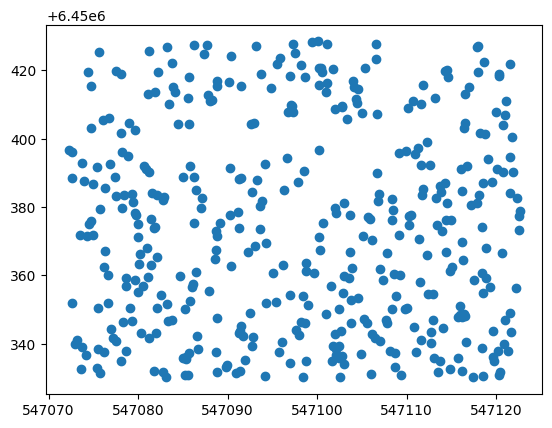

In [148]:
plt.scatter(agg["x"], agg["y"])

In [149]:
empty_points = gdf_join[gdf_join["tree_no"].isna()].sample(n = len(agg) * 2)
empty_points = empty_points.groupby(empty_points.index).agg({
    "x": "mean", "y": "mean", "z": "mean", "r": "mean", "g": "mean", "b": "mean", "intensity": "mean"
})
empty_points["is_tree"] = 0

training_df = pd.concat([agg, empty_points]).reset_index(drop=True)

In [150]:
training_df

,tree_no,z,r,g,b,x,y,intensity,is_tree
0,1.0,203.256707,73.701923,97.634615,58.336538,547075.662457,6.450425e+06,44.865385,1
1,2.0,203.255333,65.910569,102.861789,52.661247,547074.358851,6.450419e+06,45.737127,1
2,3.0,195.400165,43.514403,70.831276,39.477366,547077.495741,6.450420e+06,45.839506,1
3,4.0,198.651354,57.801556,89.856031,48.552529,547078.130296,6.450419e+06,45.501946,1
4,5.0,205.015789,72.226415,108.025157,56.283019,547074.711478,6.450416e+06,47.047170,1
...,...,...,...,...,...,...,...,...,...
1255,NaN,211.848000,49.000000,80.000000,35.000000,547122.165000,6.450426e+06,63.000000,0
1256,NaN,211.761000,73.000000,110.000000,59.000000,547125.229000,6.450432e+06,63.000000,0
1257,NaN,210.363000,30.000000,37.000000,28.000000,547124.417000,6.450429e+06,63.000000,0
1258,NaN,197.596000,43.000000,66.000000,35.000000,547125.280000,6.450344e+06,63.000000,0


<Axes: xlabel='g', ylabel='Count'>

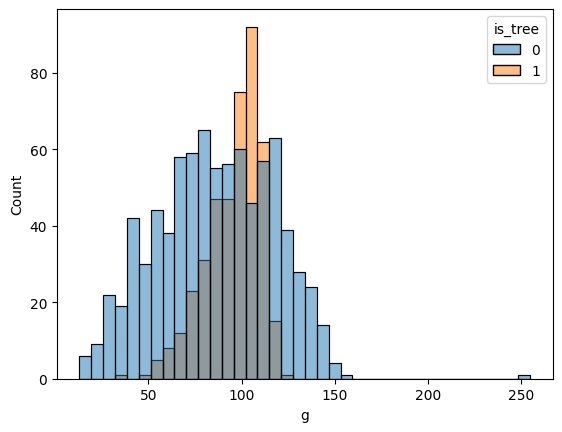

In [151]:
sns.histplot(data=training_df, x="g", hue="is_tree")


<Axes: xlabel='z', ylabel='Count'>

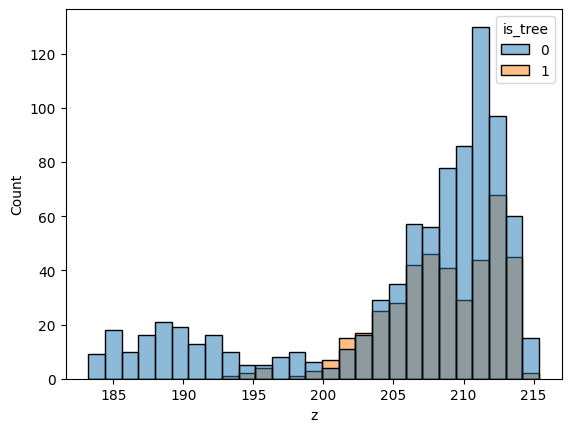

In [152]:
sns.histplot(data=training_df, x="z", hue="is_tree")


<Axes: xlabel='intensity', ylabel='Count'>

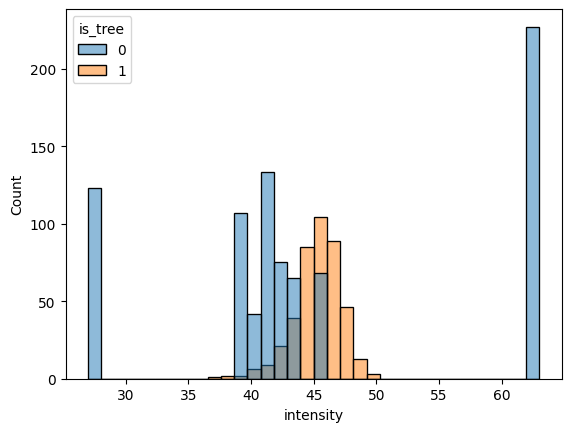

In [153]:
sns.histplot(data=training_df, x="intensity", hue="is_tree")


In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [155]:
training_df.columns

Index(['tree_no', 'z', 'r', 'g', 'b', 'x', 'y', 'intensity', 'is_tree'], dtype='object')

In [156]:

X = training_df[['z','r','g','b','intensity']].to_numpy()
y = training_df['is_tree']


In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [158]:
y_train.value_counts()

is_tree
0    588
1    294
Name: count, dtype: int64

In [159]:
y_test.value_counts()

is_tree
0    252
1    126
Name: count, dtype: int64

In [160]:
rfc_search_space = {
    'n_estimators': range(10, 101),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 51),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [161]:
rfc = RandomForestClassifier(class_weight = "balanced")

In [162]:
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_search_space, n_iter=100, cv=5)
random_search.fit(X_train, y_train)

,estimator,RandomForestC...ht='balanced')
,param_distributions,"{'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_depth': range(2, 51), 'max_features': ['sqrt', 'log2', ...], ...}"
,n_iter,100
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [163]:
best_params = random_search.best_params_
rfc = RandomForestClassifier(**best_params)

In [164]:
rfc.fit(X_train, y_train)

,n_estimators,46
,criterion,'entropy'
,max_depth,13
,min_samples_split,5
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [165]:
y_pred = rfc.predict(X_test)

In [166]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       254
           1       0.98      1.00      0.99       124

    accuracy                           0.99       378
   macro avg       0.99      1.00      0.99       378
weighted avg       0.99      0.99      0.99       378

